# Topographies

In this notebook we examine the spatial distribution of spectral features and ratio measures.

We do so by plotting topographies, and comparing spatial topographies of ratio measures to other spectral features.

In [1]:
%matplotlib inline

import csv

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib import cm

import mne

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from utils import print_stat, print_stats
from bootstrap import bootstrap_corr, bootstrap_diff
from settings import RATIO_NAMES, BAND_NAMES
from plot import plot_param_topo, plot_param_ratio_corr
from paths import DATA_PATHS as dp
from paths import FIGS_PATHS as fp

In [3]:
# Settings
SAVE_FIG = False

### Data Setup

In [4]:
# Data settings
NUM_CHAN = 111
S_RATE = 500

In [5]:
# Load data
df = pd.read_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'))

In [6]:
# Read in list of channel names that are kept in reduced 111 montage
with open(dp.make_file_path(dp.eeg_meta, 'chans111', 'csv'), 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]

In [7]:
# Read channel montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

In [8]:
# Create the info structure needed by MNE
info = mne.create_info(ch_labels, S_RATE, 'eeg')

In [9]:
# Create the MNE data object and set the montage
raw = mne.io.RawArray(np.zeros([NUM_CHAN, 1]), info, verbose=False)
raw = raw.set_montage(montage)

### Calculate per channel averages

In the data we have loaded, we have values for ratios and spectral parameters per subject per channel.

To get group average topographies, we will average each measure of interest across all channels.

Below we calculate the mean of relevant spectral features across subjects for each channel.

In [10]:
# Check out the dataframe
df.head()

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW,fit_error,fit_n_peaks,fit_r2
0,7.813890,10.0,2.576703,10.435449,0.632868,1.000000,21.527198,0.400035,0.0,1.861029,1.198543,A00051826,1.910381,14.927507,2.465467,7.168887,0.620085,0.059703,6.0,0.985572
1,6.434886,10.0,2.486382,10.419302,0.437829,1.000000,21.621280,0.398605,1.0,1.921815,1.667305,A00051826,2.560303,16.475258,2.423633,7.288577,0.636508,0.075356,5.0,0.981487
2,7.159705,10.0,3.150005,10.162052,0.562540,1.561147,23.902277,0.436887,2.0,1.928513,1.440073,A00051826,2.345069,16.790004,1.000000,7.672382,0.571536,0.062042,8.0,0.986960
3,7.314351,10.0,3.084685,10.129066,0.540991,1.116479,23.754142,0.321803,3.0,1.994314,1.536313,A00051826,2.292491,16.768082,1.291792,6.405548,0.463999,0.060083,8.0,0.987369
4,8.363157,10.0,2.832392,10.198237,0.541733,1.000000,23.822393,0.201616,4.0,2.005431,1.579849,A00051826,2.600753,21.750502,1.621394,6.952035,0.554800,0.071300,5.0,0.984456


In [11]:
# Initialize variables to hold data
exps = np.zeros(NUM_CHAN)
theta_pw = np.zeros(NUM_CHAN)
alpha_pw = np.zeros(NUM_CHAN)
beta_pw = np.zeros(NUM_CHAN)
tbrs = np.zeros(NUM_CHAN)
abrs = np.zeros(NUM_CHAN)
tars = np.zeros(NUM_CHAN)
ages = np.zeros(NUM_CHAN)
offs = np.zeros(NUM_CHAN)

# Collect average data for each channel
for chan in range(NUM_CHAN):
    
    exps[chan] = df[df.Chan_ID == chan].Exp.mean()
    theta_pw[chan] = df[df.Chan_ID == chan].Theta_PW.mean()
    alpha_pw[chan] = df[df.Chan_ID == chan].Alpha_PW.mean()
    beta_pw[chan] = df[df.Chan_ID == chan].Beta_PW.mean()
    tbrs[chan] = df[df.Chan_ID == chan].TBR.mean()
    abrs[chan] = df[df.Chan_ID == chan].ABR.mean()
    tars[chan] = df[df.Chan_ID == chan].TAR.mean()
    ages[chan] = df[df.Chan_ID == chan].Age.mean()
    offs[chan] = df[df.Chan_ID == chan].Off.mean()

### Plot Ratio Topographies

Next let's plot the topographies of the ratio measures.

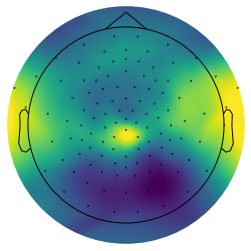

In [12]:
# Theta Alpha Ratio (TAR) topography
plot_param_topo(tars, raw, 'Ratio-TAR', SAVE_FIG)

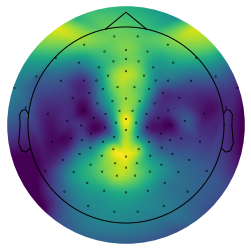

In [13]:
# Theta Beta Ratio (TBR) topography
plot_param_topo(tbrs, raw, 'Ratio-TBR', SAVE_FIG)

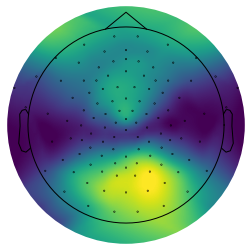

In [14]:
# Alpha Beta Ratio (ABR) topograpy
plot_param_topo(abrs, raw, 'Ratio-ABR', SAVE_FIG)

### Plot Spectral Feature Topographies

We can also plot topographies of spectral features of interest.

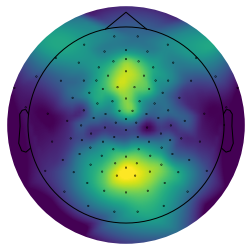

In [15]:
# Aperiodic exponent topography
plot_param_topo(exps, raw, 'Spec-AP-Exp', SAVE_FIG)

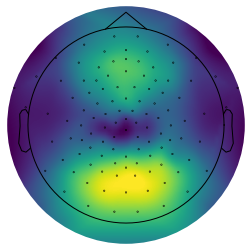

In [16]:
# Offset topography
plot_param_topo(offs, raw, 'Spec-AP-Offset', SAVE_FIG)

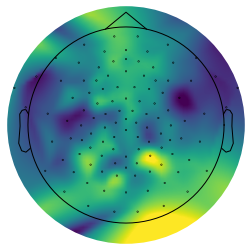

In [17]:
# Theta Power topography
plot_param_topo(theta_pw, raw, 'Spec-PE-Theta-PW', SAVE_FIG)

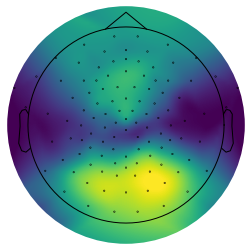

In [18]:
# Alpha Power topography
plot_param_topo(alpha_pw, raw, 'Spec-PE-Alpha-PW', SAVE_FIG)

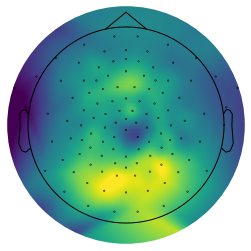

In [19]:
# Beta Power topography
plot_param_topo(beta_pw, raw, 'Spec-PE-Beta-PW', SAVE_FIG)

### Spatial Correlations

And finally, let's calculate the spatial correlations between the ratio measures and spectral parameters.

In [20]:
rs = np.zeros((3, 4))
cis = np.zeros((3, 4, 2))
ps = np.zeros((3, 4))

for ind, ratio in enumerate([tbrs, tars, abrs]):
    rs[ind, 0], cis[ind, 0, :], ps[ind, 0], = bootstrap_corr(ratio, theta_pw)
    rs[ind, 1], cis[ind, 1, :], ps[ind, 1], = bootstrap_corr(ratio, alpha_pw)
    rs[ind, 2], cis[ind, 2, :], ps[ind, 2], = bootstrap_corr(ratio, beta_pw)
    rs[ind, 3], cis[ind, 3, :], ps[ind, 3], = bootstrap_corr(ratio, exps)

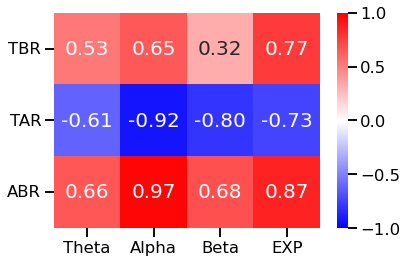

In [24]:
# Plot the correlation matrix between topographies
plot_param_ratio_corr(rs, x_labels=BAND_NAMES + ['EXP'], y_labels=RATIO_NAMES,
                      yrotation=0, save_fig=True, file_name='topos-correlations')

In [22]:
# Check the bootstrapped confidence intervals for the corrs
print_stats(rs, cis, ps, RATIO_NAMES, BAND_NAMES + ['EXP'])

TBR
	 Theta 	 +0.5262    [+0.3783, +0.6450]    0.0000
	 Alpha 	 +0.6537    [+0.5264, +0.7434]    0.0000
	 Beta 	 +0.3220    [+0.1514, +0.4682]    0.0006
	 EXP 	 +0.7666    [+0.6614, +0.8405]    0.0000
TAR
	 Theta 	 -0.6142    [-0.7264, -0.4737]    0.0000
	 Alpha 	 -0.9200    [-0.9484, -0.8706]    0.0000
	 Beta 	 -0.7965    [-0.8711, -0.6858]    0.0000
	 EXP 	 -0.7331    [-0.8116, -0.6222]    0.0000
ABR
	 Theta 	 +0.6615    [+0.5333, +0.7583]    0.0000
	 Alpha 	 +0.9750    [+0.9533, +0.9845]    0.0000
	 Beta 	 +0.6842    [+0.5345, +0.7918]    0.0000
	 EXP 	 +0.8661    [+0.8006, +0.9057]    0.0000


In [23]:
# Compare the difference in correlations between ratios, exponent, and band power
for ratio_label, ratio in zip(RATIO_NAMES, [tbrs, tars, abrs]):
    for feat_label, feat in zip(BAND_NAMES, [theta_pw, alpha_pw, beta_pw]):
        print_stat(ratio_label + '-' + feat_label, *bootstrap_diff(ratio, feat, exps))

	 TBR-Theta 	 -0.2404    [-0.3905, -0.1022]    0.0000
	 TBR-Alpha 	 -0.1129    [-0.1930, -0.0461]    0.0008
	 TBR-Beta 	 -0.4446    [-0.5672, -0.3300]    0.0000
	 TAR-Theta 	 +0.1189    [-0.0012, +0.2486]    0.0536
	 TAR-Alpha 	 -0.1869    [-0.2748, -0.1157]    0.0000
	 TAR-Beta 	 -0.0634    [-0.1789, +0.0552]    0.2700
	 ABR-Theta 	 -0.2047    [-0.3211, -0.0977]    0.0000
	 ABR-Alpha 	 +0.1088    [+0.0675, +0.1690]    0.0000
	 ABR-Beta 	 -0.1819    [-0.3255, -0.0580]    0.0020
